# Inference with OpenCV

OpenCV implements DNN library which helps you to load Caffe, Tensorflow, Yolo models to use for inference process. 

In below example, we load the caffe model with OpenCV DNN library and run object recognition on it.

- First, we import cv2 library.

- Then, we load the model files and create network. 

- Then, we set backend and target which indicates what inference platform and target hardware to use.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import time

In [2]:
network = cv.dnn.readNetFromCaffe('/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt', 
                                  '/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel')

In [3]:
network.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

## Loading image and Video with OpenCV

OpenCV has various utility methods to play with images.  

For single image, we can just use cv2.imread() 

When it comes to Video or Camera, cv2.VideoCapture object is pretty handy.

`capture = cv2.VideoCapture('file_name')` will load the video file or `capture = cv2.VideoCapture(0)` will use the attached video device from your platform. 

`capture.read()` can be used to read each from the video stream as below:

`has_frame, next_frame = cap.read()` so, with an endless loop you can read frames until you don't get any frames. 

In [4]:
frame = cv.imread('images/car.png')

At this stage, we prepare input layer for the network. CV DNN has blobFromImage to create binary object to ready for inference. 

MobileNet-SSD Model requires images sized `224x224` and normalized with scale factor `(1/256)` and mean substruction from all channels `127.` 

In [5]:
model_width = 224
model_height = 224

initial_w = frame.shape[1]
initial_h = frame.shape[0]

resized_frame = cv.resize(frame, (model_height, model_width))

scale_factor = 1/256.
mean_value = 127.

# MobileNetSSD Expects 224x224 resized frames
blob = cv.dnn.blobFromImage(resized_frame,
                            scale_factor,
                            (model_height, model_width),
                            (mean_value, mean_value, mean_value))

At this stage, we complete forward propagation from the Neural Network to get detections from MobileNet SSD.

In [6]:
# Send blob data to Network
inference_start = time.time()
network.setInput(blob)
# Make network do a forward propagation to get recognition matrix
res = network.forward()
inference_end = time.time()


0.07897448539733887  seconds


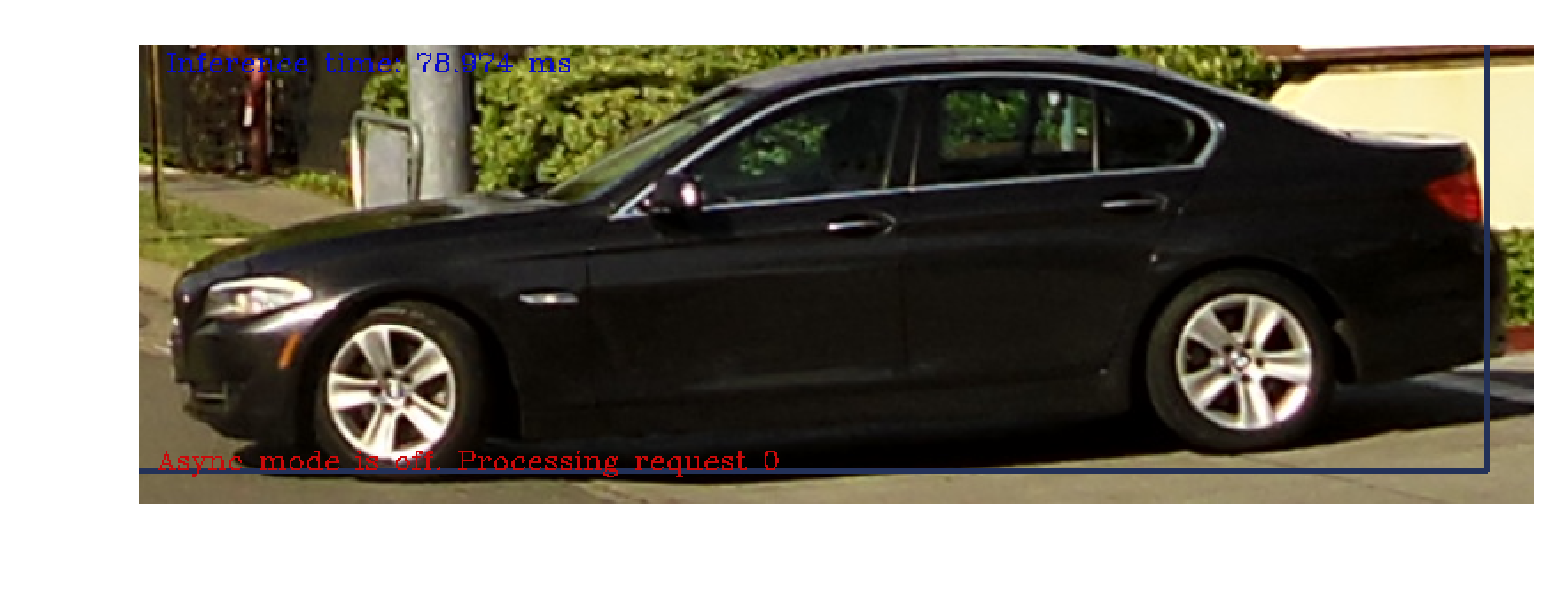

In [7]:
# Post Process 
# For labeling the image after inference.
from out_process import placeBoxes

inference_time = (inference_end - inference_start)
print(inference_time, ' seconds')

confidence_threshold = 0.6

frame = placeBoxes(res, 
                   None, 
                   confidence_threshold, 
                   frame, initial_w, initial_h, 
                   False, 0, inference_time)

# We use pyplot because it plays nicer with Jupyter Notebooks
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB), interpolation='none')
plt.axis("off")
plt.show()

# Inference Engine Integration

Now, we can run the existing applications and see how they have been improved with OpenVINO integration to existing software. 

We have developed a Python application using OpenCV and OpenVINO Python APIs to run real-time object detections with on given video source. 

We will begin with running Inference on OpenCV then OpenVINO with different hardware configurations.

Open a new terminal and Setup Environment Variables

```bash
source /opt/intel/computer_vision_sdk/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized

```


- Run OpenCV Inference with Following Command

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework caffe --device CPU --backend OPENCV_DNN --mconfig /home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt --mweight /home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel --mlabels /home/intel/Notebooks/ssd_labels.txt -i offline --source /home/intel/Notebooks/videos/cars_1900.mp4 --model_image_height 224 --model_image_width 224 --confidence 0.60

Inference for 1 Frame: 32.368  milliseconds

```

- Run OpenVINO CPU Inference

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework openvino --device CPU --mconfig /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.xml --mweight /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.bin --mlabels /home/intel/Notebooks/ssd_labels.txt -i offline --source /home/intel/Notebooks/videos/cars_1900.mp4 --model_image_height 224 --model_image_width 224 --confidence 0.60 --async True --number_of_async_requests 20 --pc False

Inference for 1 Frame: 19.89  milliseconds

```


- Run OpenVINO GPU Inference

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework openvino --device GPU --mconfig /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.xml --mweight /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.bin --mlabels /home/intel/Notebooks/ssd_labels.txt -i offline --source /home/intel/Notebooks/videos/cars_1900.mp4 --model_image_height 224 --model_image_width 224 --confidence 0.60 --async True --number_of_async_requests 20 --pc False

Inference for 1 Frame: 20.862  milliseconds

```

- GPU FP16 

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework openvino --device GPU --mconfig /home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.xml --mweight /home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.bin --mlabels /home/intel/Notebooks/ssd_labels.txt -i offline --source /home/intel/Notebooks/videos/cars_1900.mp4 --model_image_height 224 --model_image_width 224 --confidence 0.60 --async True --number_of_async_requests 10 --pc False

Inference for 1 Frame: 41.791  milliseconds

```

- Run OpenVINO MYRIAD Inference

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework openvino --device MYRIAD --mconfig /home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.xml --mweight /home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.bin --mlabels /home/intel/Notebooks/ssd_labels.txt -i offline --source /home/intel/Notebooks/videos/cars_1900.mp4 --model_image_height 224 --model_image_width 224 --confidence 0.60 --async True --number_of_async_requests 10 --pc False

Inference for 1 Frame: 67.072  milliseconds
```

In order to use usb or built-in camera, you can change `offline` to `live` and change source parameter to 0 or any other camera index.

e.g.

```bash
python3 /home/intel/Notebooks/samples/object_detection_multi_platform.py --framework openvino --device CPU --mconfig /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.xml --mweight /home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.bin --mlabels /home/intel/Notebooks/ssd_labels.txt -i live --source 0 --model_image_height 224 --model_image_width 224 --confidence 0.60 --async True --number_of_async_requests 20 --pc False

Inference for 1 Frame: 19.89  milliseconds

```

# Use of Multiple Models (Intel Models)

At this part, we will look into OpenVINO sample codes where, multiple models is being used and how we can configure our system to use different hardware for different models. 

One of the greatest example is Interactive Face Detection Demo.

Source code delivered under: `/opt/intel/computer_vision_sdk/deployment_tools/inference_engine/samples/interactive_face_detection_demo/`

How It Works

- The application reads command line parameters loads up to four networks, depending on -m... options family to the Inference Engine.
- The application gets a frame from the OpenCV VideoCapture.
- The application performs inference on the frame detection network.
- The application performs four simultaneous inferences, using the Age/Gender Recognition, Head Pose Estimation, Emotions Recognition, and Facial Landmarks Estimation networks if those are specified in command line.
- The application displays the results.

```bash

./interactive_face_detection_demo -h
InferenceEngine:
    API version ............ <version>
    Build .................. <number>

interactive_face_detection_demo [OPTION]
Options:

    -h                         Print a usage message.
    -i "<path>"                Optional. Path to an video file. Default value is "cam" to work with camera.
    -m "<path>"                Required. Path to an .xml file with a trained face detection model.
    -m_ag "<path>"             Optional. Path to an .xml file with a trained age gender model.
    -m_hp "<path>"             Optional. Path to an .xml file with a trained head pose model.
    -m_em "<path>"             Optional. Path to an .xml file with a trained emotions model.
    -m_lm "<path>"             Optional. Path to an .xml file with a trained facial landmarks model.
      -l "<absolute_path>"     Required for MKLDNN (CPU)-targeted custom layers. Absolute path to a shared library with the kernels impl.
          Or
      -c "<absolute_path>"     Required for clDNN (GPU)-targeted custom kernels. Absolute path to the xml file with the kernels desc.
    -d "<device>"              Specify the target device for Face Detection (CPU, GPU, FPGA, or MYRIAD). The demo will look for a suitable plugin for a specified device.
    -d_ag "<device>"           Specify the target device for Age Gender Detection (CPU, GPU, FPGA, or MYRIAD). The demo will look for a suitable plugin for a specified device.
    -d_hp "<device>"           Specify the target device for Head Pose Detection (CPU, GPU, FPGA, or MYRIAD). The demo will look for a suitable plugin for a specified device.
    -d_em "<device>"           Specify the target device for Emotions Detection (CPU, GPU, FPGA, or MYRIAD). The demo will look for a suitable plugin for a specified device.
    -d_lm "<device>"           Specify the target device for Facial Landmarks Detection (CPU, GPU, FPGA, or MYRIAD). The demo will look for a suitable plugin for device specified.
    -n_ag "<num>"              Specify number of maximum simultaneously processed faces for Age Gender Detection (default is 16).
    -n_hp "<num>"              Specify number of maximum simultaneously processed faces for Head Pose Detection (default is 16).
    -n_em "<num>"              Specify number of maximum simultaneously processed faces for Emotions Detection (default is 16).
    -n_lm "<num>"              Specify number of maximum simultaneously processed faces for Facial Landmarks Detection (default is 16).
    -dyn_ag                    Enable dynamic batch size for AgeGender net.
    -dyn_hp                    Enable dynamic batch size for HeadPose net.
    -dyn_em                    Enable dynamic batch size for Emotions net.
    -dyn_lm                    Enable dynamic batch size for Facial Landmarks net.
    -async                     Enable asynchronous mode
    -no_wait                   No wait for key press in the end.
    -no_show                   No show processed video.
    -pc                        Enables per-layer performance report.
    -r                         Inference results as raw values.
    -t                         Probability threshold for detections.

```


You can try out following examples to see multiple models is being used and how they run on different hardware.

Before going forward, open a new terminal and set environment variables.

Main idea of such application is to see that OpenVINO allows you to allocate targets for different model executions for within the same application. 


```bash

source /opt/intel/computer_vision_sdk/bin/setupvars.sh
```

Then, to ease the process of locating models, define a parameter where face detection models are stored. 

```bash

export INTEL_MODELS=/opt/intel/computer_vision_sdk/deployment_tools/intel_models/
cd /opt/intel/inference_engine_samples/intel64/Release

```

- Run Face Detection with CPU

```bash
./interactive_face_detection_demo -i cam -m $INTEL_MODELS/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -d CPU
```

- Add Age/Gender Recognition Model and run it on CPU

```bash

./interactive_face_detection_demo -i cam -m $INTEL_MODELS/face-detection-retail-0004/FP16/face-detection-retail-0004.xml -d GPU -m_ag $INTEL_MODELS/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml -d_ag CPU 
```

- Let's run Face-detection on MYRIAD , Age/Gender detection on CPU and Head-Pose Estimation on GPU

```bash

./interactive_face_detection_demo -i cam -m $INTEL_MODELS/face-detection-retail-0004/FP16/face-detection-retail-0004.xml -d MYRIAD -m_ag $INTEL_MODELS/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml -d_ag CPU -m_hp $INTEL_MODELS/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml -d_hp GPU
```

- Let's run Emotion detection model on GPU

```bash

./interactive_face_detection_demo -i cam -m $INTEL_MODELS/face-detection-retail-0004/FP16/face-detection-retail-0004.xml -d MYRIAD -m_ag $INTEL_MODELS/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml -d_ag CPU -m_hp $INTEL_MODELS/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml -d_hp GPU -m_em $INTEL_MODELS/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.xml -d_em GPU
```

- Finally, we can add landmark detection model and run it on GPU as well. 

```bash

./interactive_face_detection_demo -i cam -m $INTEL_MODELS/face-detection-retail-0004/FP16/face-detection-retail-0004.xml -d MYRIAD -m_ag $INTEL_MODELS/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml -d_ag CPU -m_hp $INTEL_MODELS/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml -d_hp GPU -m_em $INTEL_MODELS/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.xml -d_em GPU -m_lm $INTEL_MODELS/facial-landmarks-35-adas-0001/FP16/facial-landmarks-35-adas-0001.xml -d_lm GPU

```

You will get outputs as below. Sample application prints the loaded plugins.

```bash

InferenceEngine: 
	API version ............ 1.4
	Build .................. 19154
[ INFO ] Parsing input parameters
[ INFO ] Reading input
[ INFO ] Loading plugin GPU

	API version ............ 1.5
	Build .................. 19154
	Description ....... clDNNPlugin
[ INFO ] Loading plugin CPU

	API version ............ 1.5
	Build .................. lnx_20181004
	Description ....... MKLDNNPlugin
[ INFO ] Loading network files for Face Detection
[ INFO ] Batch size is set to 1
[ INFO ] Checking Face Detection network inputs
[ INFO ] Checking Face Detection network outputs
[ INFO ] Loading Face Detection model to the GPU plugin
[ INFO ] Loading network files for Age/Gender Recognition network
[ INFO ] Batch size is set to 16 for Age/Gender Recognition network
[ INFO ] Checking Age/Gender Recognition network inputs
[ INFO ] Checking Age/Gender Recognition network outputs
[ INFO ] Age layer: age_conv3
[ INFO ] Gender layer: prob
[ INFO ] Loading Age/Gender Recognition model to the CPU plugin
[ INFO ] Loading network files for Head Pose Estimation network
[ INFO ] Batch size is set to  16 for Head Pose Estimation network
[ INFO ] Checking Head Pose Estimation network inputs
[ INFO ] Checking Head Pose Estimation network outputs
[ INFO ] Loading Head Pose Estimation model to the GPU plugin
[ INFO ] Loading network files for Emotions Recognition
[ INFO ] Batch size is set to 16 for Emotions Recognition
[ INFO ] Checking Emotions Recognition network inputs
[ INFO ] Checking Emotions Recognition network outputs
[ INFO ] Emotions layer: prob_emotion
[ INFO ] Loading Emotions Recognition model to the GPU plugin
[ INFO ] Loading network files for Facial Landmarks Estimation
[ INFO ] Batch size is set to  16 for Facial Landmarks Estimation network
[ INFO ] Checking Facial Landmarks Estimation network inputs
[ INFO ] Checking Facial Landmarks Estimation network outputs
[ INFO ] Loading Facial Landmarks Estimation model to the GPU plugin
[ INFO ] Start inference 
Press any key to stop
[ INFO ] Number of processed frames: 203
[ INFO ] Total image throughput: 8.74646 fps
[ INFO ] Execution successful


```

# Intel Distribution of OpenVINO : Heterogenous Plugin

At this session, we would like to go over more detailed explanation of OpenVINO Inference Engine's Heterogeneous API which helps to run inference on heterogeneous platforms. If you are running on a platform with Intel CPU and GPU, you can control what layers of Deep Learning Model would be running on the selected hardware platform. 

Heterogeneous API has been developed first with fallback principle, it means we wanted to execute layers and methods with a prioritized order. Not all layer's implementations are complete for each platform and certain layers can execute a lot faster on different platforms where some can't. As such, there has been great progress over the heterogeneous API use cases for Inference to analyze the performance bottlenecks and improve the inference process. 

At this section, we want to showcase its use on object detection scenario and get detailed analysis of executions of layers on devices a quick course of Heterogeneous Plugin of Intel OpenVINO.  

Let's start importing required libraries for this session as following cell.  

In [8]:
# Let's Import Required Libraries first
import sys
import os
import time
import cv2 as cv
import numpy as np
from demoutils import videoHTML,liveQstat, summaryPlot, progressIndicator
from IPython.display import HTML
import matplotlib.pyplot as plt

%matplotlib inline 

I have copied, createNetwork, loadNetwork and preprocessImage methods from Hands-on Lab 1 because I will directly re-use them. 

In [9]:
# Import OpenVINO
from openvino.inference_engine import IENetwork, IEPlugin

# Define Methods

def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.

    net = IENetwork(model=model_xml, weights=model_bin)
        
    return net

def loadNetwork(plugin, net, num_requests=2):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=num_requests)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    
    return exec_net,input_blob,out_blob

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    
    return in_frame.reshape((n, c, h, w)),frame

At this part, we are implementing a new inference method which is working with heterogeneour plugin. 

There are couple more steps we have added to inference process.

- First we check if there is a CPU device on the list of devices, we load cpu extensions library.

- Then, we load the network as usual process. 

-  `set_config` function configures the plugin fallback devices and their order.

Heterogeneous Plugin used with `HETERO:` prefix, which is followed with a list of devices, according to their prioritization. 

- After network load, we send the network to plugin to set affinity of layers according to priority list we give to plugin. When affinity sets the layer's target device to be executed.

- Additionally we have performance counters or certain outputs we can later analyze the network. `.set_config({"HETERO_DUMP_GRAPH_DOT": "YES"})` prints .dot output which has a detailed graph representation of model. 

- Finally, `get_perf_counts` method prints the detailed execution times of layers on the devices.

Let's run the next cell and make `runInference` method ready.

In [10]:
# For labeling the image after inference.
from out_process import placeBoxes

# At this stage we implement our inference method to run with Heterogeneous plugin. 

def runInference(hetero_device = 'HETERO:GPU,CPU',
                 model_xml='/home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.xml',
                 model_bin='/home/intel/openvino_models/ir/mobilenet-ssd/FP32/mobilenet-ssd.bin',
                 image_file='images/car.png',
                 performance_counters = False,
                 dot_graph = True,
                 confidence_threshold=0.6):

    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device=hetero_device, plugin_dirs='/opt/intel/computer_vision_sdk/inference_engine/lib/ubuntu_16.04/intel64')
    
    # Heterogeneous Plugin is provided as
    #HETERO:GPU,CPU or similar.
    vals = hetero_device.split(':')
    targets = vals[1].split(',')
    
    # Let's check if heterogeneous plugin has CPU target so we can add cpu extensions
    # Loading additional exension libraries for the CPU
    if hetero_device == 'CPU' or ('CPU' in targets):
        extension_list=['/home/intel/inference_engine_samples/intel64/Release/lib/libcpu_extension.so']
        for extension in extension_list:
            plugin.add_cpu_extension(extension)
 
    net = createNetwork(model_xml, model_bin, plugin)
    
     # Let's check if the target is heterogeneous then we add fallback device priorities
     #If we set TARGET_FALLBACK configuration, we want IE to decide what device to fallback. 
    
    plugin.set_initial_affinity(net)
    plugin.set_config({"TARGET_FALLBACK": hetero_device})
    
    if dot_graph:
        # Just for a show case, remove
        plugin.set_config({"HETERO_DUMP_GRAPH_DOT": "YES"})
    
    exec_net, input_blob, out_blob = loadNetwork(plugin, net)
    
    in_frame,original_frame = preprocessImage(image_file, net, input_blob)

    my_request_id = 0

        # Starting the inference in async mode, which starts the inference in parallel
    inference_start = time.time()
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]
        inference_end = time.time()
        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]

        frame = placeBoxes(res, None, confidence_threshold, original_frame, initial_w, initial_h, False, my_request_id, ((inference_end - inference_start)))
        # We use pyplot because it plays nicer with Jupyter Notebooks
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")
    
    if performance_counters:
        perf_counts = exec_net.requests[0].get_perf_counts()
        print("Performance counters:")
        for layer, stats in perf_counts.items():
            print(layer, ': ', stats)
    
    return (plugin, net, exec_net)

In next cell, I would like to use Heterogeneous plugin to run object detection sample. 

With `HETERO:GPU,CPU,MYRIAD` we indicate to our plugin to prioritize `GPU > CPU > MYRIAD` for layers to be executed. 

For MobileNet-SSD example, almost all layers can run on GPU except `PriorBox` Caffe layer. Therefore, it will use GPU for all the `Convolution` layers and CPU for PriorBox layer.

If, we have been used `HETERO:GPU,MYRIAD,CPU` , `PriorBox` layer would be running on MYRIAD since it has also support for it. 

Note that, we use FP16 because, in case CPU target is being used, IE helps to convert FP16 layers to FP32 automatically.  

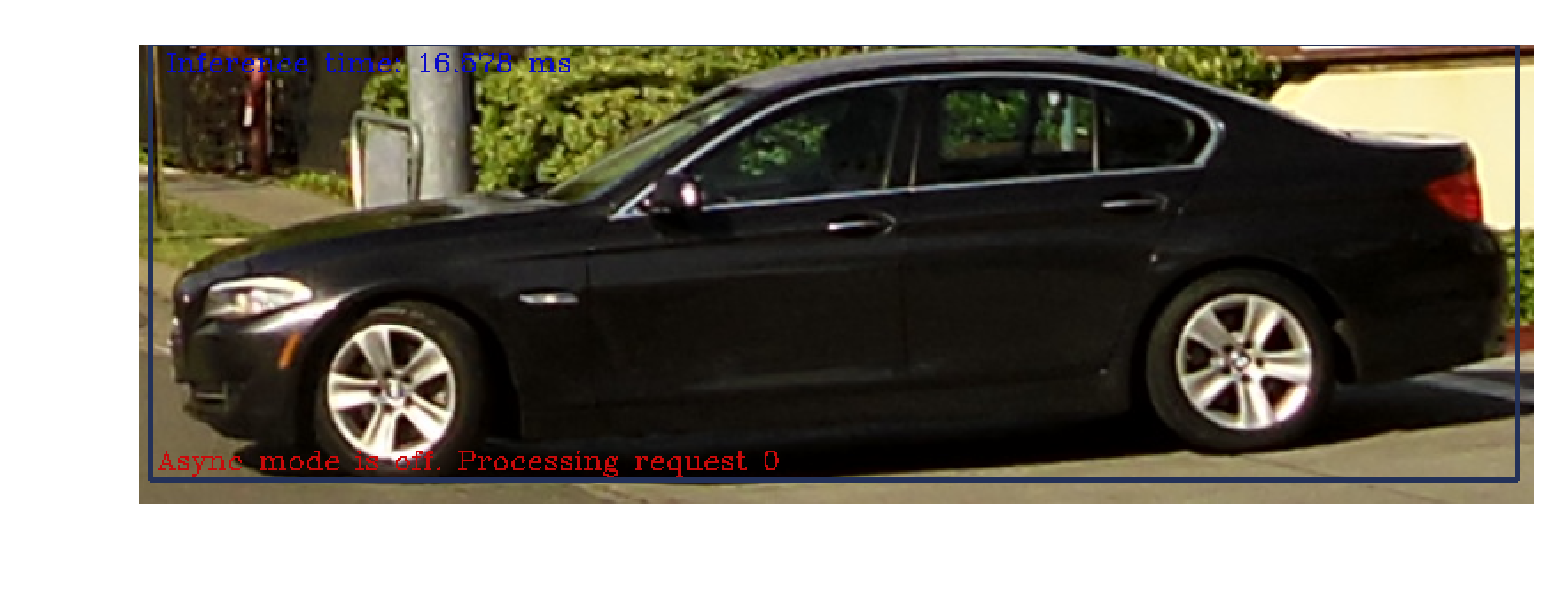

In [11]:
# NOTE: 
hetero_objects = runInference(hetero_device = 'HETERO:GPU,CPU',
                              model_xml='/home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

Let's first see the affinity of the layers. 

Below example shows that, Input layer uses CPU and ScaleShift uses GPU.

`
Type:  Input Device:  CPU
Type:  ScaleShift Device:  GPU
Type:  Convolution Device:  GPU
`

In [12]:
net = hetero_objects[1]

for l in net.layers.values():
    print('Type: ', l.type, 'Device: ', l.affinity)

Type:  Input Device:  CPU
Type:  ScaleShift Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU

`{"HETERO_DUMP_GRAPH_DOT": "YES"}` configuraion let's us to print the network visualisation in .dot graph format. You can navigate to current directory and run it as below from a new terminal.


```bash
!xdot hetero_affinity_MobileNet-SSD.dot
```

![Dot Output](images/affinity_dot.png)

Let's see the detailed run of execution of layers. Following command will give us the layer executions in details. 

In [13]:
# Get the exec net
exec_net = hetero_objects[2]

# Print the performance counteres
perf_counts = exec_net.requests[0].get_perf_counts()
print("Performance counters:")
for layer, stats in perf_counts.items():
    print(layer, ': ', stats)

# Note: GPU Perfomance Counters Don't Output

Performance counters:


You can try out:

`'HETERO:MYRIAD,GPU,CPU'` and so on. 

Note: if you get NCS2 Not Found Error you install NCS2 as below. 


```bash
cat <<EOF > 97-usbboot.rules
SUBSYSTEM=="usb", ATTRS{idProduct}=="2150", ATTRS{idVendor}=="03e7", GROUP="users", MODE="0666", ENV{ID_MM_DEVICE_IGNORE}="1"
SUBSYSTEM=="usb", ATTRS{idProduct}=="2485", ATTRS{idVendor}=="03e7", GROUP="users", MODE="0666", ENV{ID_MM_DEVICE_IGNORE}="1"
SUBSYSTEM=="usb", ATTRS{idProduct}=="f63b", ATTRS{idVendor}=="03e7", GROUP="users", MODE="0666", ENV{ID_MM_DEVICE_IGNORE}="1"
EOF
```

```bash
sudo cp 97-usbboot.rules /etc/udev/rules.d/
sudo udevadm control --reload-rules
sudo udevadm trigger
sudo ldconfig
rm 97-usbboot.rules
```

In [14]:
# Before re-run delete objects
del hetero_objects

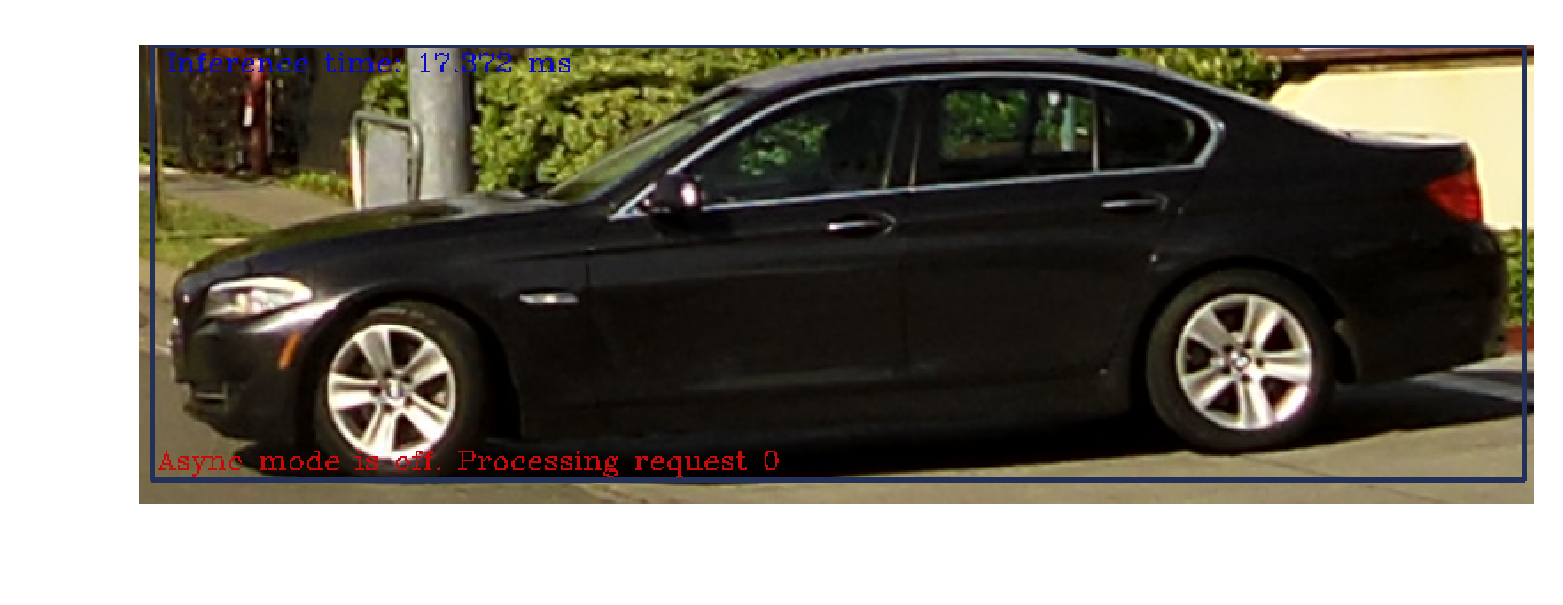

Performance counters:
subgraph0: conv16_1 :  {'cpu_time': 12, 'real_time': 12, 'exec_type': 'jit_avx2_1x1_FP32', 'layer_type': 'Convolution', 'status': 'EXECUTED'}
subgraph0: conv3/dw :  {'cpu_time': 0, 'real_time': 0, 'exec_type': 'undef', 'layer_type': 'Convolution', 'status': 'NOT_RUN'}
subgraph0: conv17_2_mbox_priorbox :  {'cpu_time': 0, 'real_time': 0, 'exec_type': 'unknown_FP32', 'layer_type': 'PriorBox', 'status': 'NOT_RUN'}
subgraph0: conv13/dw/relu :  {'cpu_time': 0, 'real_time': 0, 'exec_type': 'undef', 'layer_type': 'ReLU', 'status': 'NOT_RUN'}
subgraph0: conv13/dw :  {'cpu_time': 53, 'real_time': 53, 'exec_type': 'jit_avx2_dw_FP32', 'layer_type': 'Convolution', 'status': 'EXECUTED'}
subgraph0: conv1/dw :  {'cpu_time': 0, 'real_time': 0, 'exec_type': 'undef', 'layer_type': 'Convolution', 'status': 'NOT_RUN'}
subgraph0: conv11_mbox_loc_flat :  {'cpu_time': 0, 'real_time': 0, 'exec_type': 'unknown_FP32', 'layer_type': 'Flatten', 'status': 'NOT_RUN'}
subgraph0: conv4/dw :  {'cp

In [15]:
hetero_objects = runInference(hetero_device = 'HETERO:CPU,GPU',
                              model_xml='/home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/ir/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

# Get the exec net
exec_net = hetero_objects[2]

# Print the performance counteres
perf_counts = exec_net.requests[0].get_perf_counts()
print("Performance counters:")
for layer, stats in perf_counts.items():
    print(layer, ': ', stats)

In [16]:
net = hetero_objects[1]

for l in net.layers.values():
    print('Type: ', l.type, 'Device: ', l.affinity)

Type:  Input Device:  CPU
Type:  ScaleShift Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU